In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal, wilcoxon, friedmanchisquare
from statsmodels.stats.multitest import multipletests


In [ ]:
path = '../data/results-2026-01-17-165719/results.csv'

# df = pd.read_csv('../data/results-2026-01-08-190113.csv', index_col=0)
df_raw = pd.read_csv(path, index_col=None)

cols_of_interest = ['total_faults', 'faults_detected', 'fdl', 'test_suite', 'language', 'budget_prop_requested', 'random_seed', 'method', 'algorithm_family', 'representation']


df = df_raw[cols_of_interest].rename(columns={"budget_prop_requested": "budget"}).copy()
df = df[df['language'] == "C"]


In [3]:
df.head()

,total_faults,faults_detected,fdl,test_suite,language,budget,random_seed,method,algorithm_family,representation
0,9,5,0.444444,flex_v3,C,0.05,166766486,random_baseline,random,SuiteLength
1,9,5,0.444444,flex_v3,C,0.10,166766486,random_baseline,random,SuiteLength
2,9,6,0.333333,flex_v3,C,0.15,166766486,random_baseline,random,SuiteLength
3,9,6,0.333333,flex_v3,C,0.20,166766486,random_baseline,random,SuiteLength
4,9,8,0.111111,flex_v3,C,0.25,166766486,random_baseline,random,SuiteLength


In [4]:
df.groupby(by=["method"]).agg({
    "total_faults": "mean",
    "faults_detected": "mean",
    "fdl": "mean",
}).reset_index()

,method,total_faults,faults_detected,fdl
0,cs_emb,5.4,4.052364,0.347467
1,cs_tf_srp,5.4,4.056545,0.355047
2,pp_emb,5.4,4.095273,0.340713
3,pp_tf_srp,5.4,4.004727,0.353390
4,random_baseline,5.4,4.161636,0.344777


In [5]:
pivot = df.pivot(columns='method', index=['test_suite', 'budget', 'random_seed'], values='fdl')

pivot.head()

method                         cs_emb  cs_tf_srp  pp_emb  pp_tf_srp  \
test_suite budget random_seed                                         
chart_v1   0.05   5259293         1.0        1.0     1.0        1.0   
                  58243253        1.0        1.0     1.0        1.0   
                  137113079       1.0        1.0     1.0        1.0   
                  226942979       1.0        1.0     1.0        1.0   
                  228456478       1.0        1.0     1.0        1.0   

method                         random_baseline  
test_suite budget random_seed                   
chart_v1   0.05   5259293                  1.0  
                  58243253                 1.0  
                  137113079                1.0  
                  226942979                1.0  
                  228456478                1.0

In [6]:
friedman_results = friedmanchisquare(pivot['cs_tf_srp'], pivot['cs_emb'], pivot['pp_tf_srp'], pivot['pp_emb'], pivot['random_baseline'])

print(f"Friedman test statistic: {friedman_results.statistic}, p-value: {friedman_results.pvalue}")

if friedman_results.pvalue < 0.05:
    print("Significant differences found between methods, proceeding to pairwise Wilcoxon tests.")

Friedman test statistic: 103.33638717386084, p-value: 1.915742166843128e-21
Significant differences found between methods, proceeding to pairwise Wilcoxon tests.


In [7]:
results = []
for method1 in df['method'].unique():
    for method2 in df['method'].unique():
        if method1 == method2:
            continue

        test_result = wilcoxon(pivot[method1], pivot[method2], alternative = 'less')
        
        result = {
            "method1": method1,
            "method2": method2,
            "pval": test_result.pvalue,
        }

        results.append(result)

results = pd.DataFrame(results)
results["reject"] = multipletests(results['pval'], alpha=0.05, method='holm')[0]
results["p_adj"] = multipletests(results['pval'], alpha=0.05, method='holm')[1]

results.sort_values(by='p_adj')

,method1,method2,pval,reject,p_adj
19,pp_emb,pp_tf_srp,0.000005,True,0.000104
17,pp_emb,cs_tf_srp,0.000008,True,0.000149
16,pp_emb,random_baseline,0.001881,True,0.033850
18,pp_emb,cs_emb,0.007467,False,0.126937
9,cs_emb,cs_tf_srp,0.007715,False,0.126937
10,cs_emb,pp_tf_srp,0.017126,False,0.256894
0,random_baseline,cs_tf_srp,0.068207,False,0.954899
5,cs_tf_srp,cs_emb,0.992285,False,1.000000
6,cs_tf_srp,pp_tf_srp,0.635436,False,1.000000
7,cs_tf_srp,pp_emb,0.999992,False,1.000000


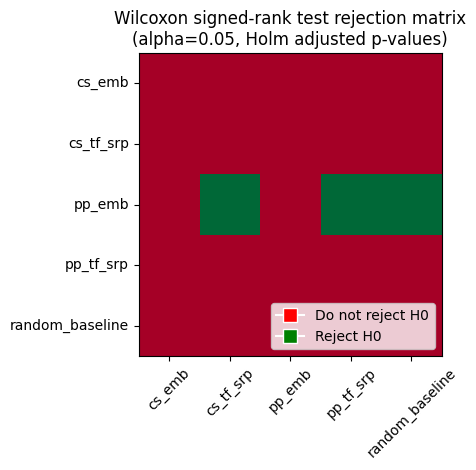

In [8]:
rejection_mat = results.pivot_table(values="reject", index='method1', columns='method2').fillna(0)

ax = plt.imshow(rejection_mat.to_numpy(), cmap='RdYlGn', vmin=0, vmax=1)
# binary legend instead of continuous
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='w', label='Do not reject H0', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='s', color='w', label='Reject H0', markerfacecolor='green', markersize=10)], loc='lower right')

plt.xticks(ticks=np.arange(len(rejection_mat.columns)), labels=rejection_mat.columns, rotation=45)
plt.yticks(ticks=np.arange(len(rejection_mat.index)), labels=rejection_mat.index, rotation=0, va='center')

plt.title("Wilcoxon signed-rank test rejection matrix\n(alpha=0.05, Holm adjusted p-values)")
plt.tight_layout()
plt.show()

In [9]:
df = df_raw.copy()

df = df[df['representation'] != 'SuiteLength']

<Axes: xlabel='reduction_time_ns', ylabel='Density'>

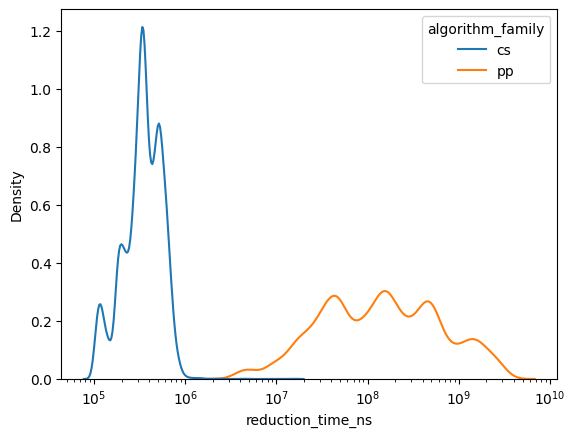

In [10]:
sns.kdeplot(df, x="reduction_time_ns", hue="algorithm_family", log_scale=True)

<Axes: xlabel='preperation_time_ns', ylabel='Density'>

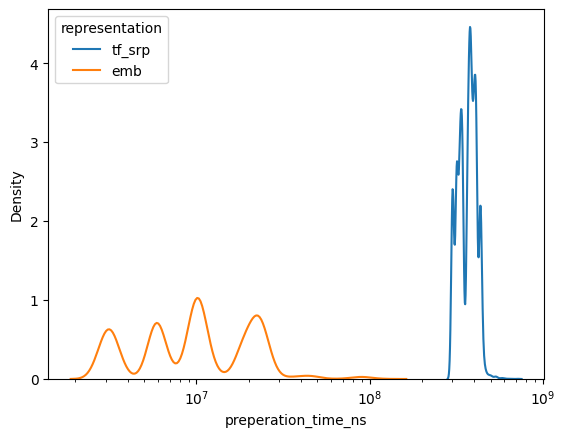

In [11]:
sns.kdeplot(df, x="preperation_time_ns", hue="representation", log_scale=True)